<a href="https://colab.research.google.com/github/fl-man/ravin_warp/blob/main/warp_image_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1431]:
def project_to_pixel_MBC(x, y, z, camParams, calParams):
  # takes a point in 3D space and maps it onto a camera pixel
  # adapted from rs2_project_point_to_pixel() ...
  # at github.com in IntelRealSense/librealsense/include/librealsense2/rsutil.h
  # distortion model for D455 is "modified brown conrady" or MBC

  z = z + calParams[2];
  x = calParams[3] * (x + calParams[0]) / z;
  y = calParams[3] * (y + calParams[1]) / z;
  r2  = x**2 + y**2;
  f = 1 + camParams[0] * r2 + camParams[1] * r2**2 + camParams[4] * r2**3;
  x = x * f;
  y = y * f;
  dx = x + 2 * camParams[2] * x * y + camParams[3] * (r2 + 2 * x**2);
  dy = y + 2 * camParams[3] * x * y + camParams[2] * (r2 + 2 * y**2);
  x = dx;
  y = dy;
  pixelx = x * camParams[5] + camParams[7];
  pixely = y * camParams[6] + camParams[8];

  return [pixelx, pixely]

In [1432]:
def invert_and_find_fov(image):
  # filps sign of CA image and removes pixels outside FOV
  image = np.max(image)-image;
  firstVal = image[0][0];
  for i in range(len(image)):
    for j in range(len(image[0])): # scan from left
      if image[i][j]  == firstVal:
        image[i][j] = np.nan
      else:
        break
    for j in range(len(image[0])-1, -1, -1): # scan from right
      if image[i][j]  == firstVal:
        image[i][j] = np.nan
      else:
        break
  return image

In [1433]:
def apply_thresh(cai_gray):
  # calculates threshold below which will be transparent
    nSig = 5;
    image_sort = cai_gray.ravel();
    image_sort = image_sort[~np.isnan(image_sort)]
    image_sort = np.sort(image_sort)
    n = -1
    while np.mean(image_sort[:n]) > np.median(image_sort[:n]):
      n = n - 1
    med = np.median(image_sort[:n]) - image_sort[0]
    sig = np.std(image_sort[:n])
    thresh = image_sort[0] + np.max([med + nSig * sig, 2 * med]);
    cai_gray[(np.isnan(cai_gray)) | (cai_gray < thresh)] = 0
    return cai_gray

In [1434]:
def rgb2gray(image_rgb):
  # converts RGB image with jet colormap to grayscale intensity (between 0 and 1)

  # initialize things
  edgeVal = 0.508 # jet colormap
  frac = [0.1259, 0.3776, 0.6276, 0.8741, 1] # jet colormap
  cmap_eps = 0.02; # png values don't quite reach 0 or 255, not sure why
  image_gray = np.zeros(np.shape(image_rgb[:,:,0]))
  image_rgb = image_rgb/255

  # different mapping rules for different intensity bands
  r0 = (image_rgb[:,:,0] == 0) & (image_rgb[:,:,1] == 0) & (image_rgb[:,:,2] >= edgeVal)
  r1 = (image_rgb[:,:,0] == 0) & (image_rgb[:,:,1] < 1) & (image_rgb[:,:,2] > 1-cmap_eps)
  r2 = (image_rgb[:,:,0]  < 1) & (image_rgb[:,:,2] < 1) & (image_rgb[:,:,1] > 1-cmap_eps)
  r3 = (image_rgb[:,:,0]  > 1-cmap_eps) & (image_rgb[:,:,1]  < 1) & (image_rgb[:,:,2] < cmap_eps)
  r4 = (image_rgb[:,:,0]  >= edgeVal) & (image_rgb[:,:,1] < cmap_eps) & (image_rgb[:,:,2] < cmap_eps)

  # interpolate image values
  image_gray[r0] = ((image_rgb[:,:,2])[r0] - edgeVal) / (1-edgeVal) * frac[0]
  image_gray[r1] = frac[0] + (image_rgb[:,:,1])[r1] * (frac[1] - frac[0])
  image_gray[r2] = frac[1] + (1-(image_rgb[:,:,2])[r2]) * (frac[2] - frac[1])
  image_gray[r3] = frac[2] + (1-(image_rgb[:,:,1])[r3]) * (frac[3] - frac[2])
  image_gray[r4] = frac[4] + ((image_rgb[:,:,0])[r4] - edgeVal)/(1-edgeVal) * (frac[3] - frac[4])

  return image_gray

In [1435]:
def gray2rgba(image_gray):
  # converts grayscale image (between 0 and 1) to RGBA image with jet colormap

  # initialize
  edgeVal = 0.508 # jet colormap
  frac = [0.1259, 0.3776, 0.6276, 0.8741, 1] # jet colormap
  image_rgba = np.zeros((image_gray.shape[0],image_gray.shape[1],4), dtype='uint8')
  nzvals = image_gray>0;
  if np.sum(nzvals) == 0:
    return image_rgba
  minVal = np.min(image_gray[nzvals])
  image_gray[nzvals] = (image_gray[nzvals]-minVal)/(1-minVal)

  # different mapping rules for different intensity bands
  r0 = image_gray <= frac[0];
  r1 = (image_gray > frac[0]) & (image_gray <= frac[1])
  r2 = (image_gray > frac[1]) & (image_gray <= frac[2])
  r3 = (image_gray > frac[2]) & (image_gray <= frac[3])
  r4 = (image_gray > frac[3]) & (image_gray <= frac[4])

  # red
  (image_rgba[:,:,0])[r2] = 255 * (image_gray[r2]-frac[1])/(frac[2] - frac[1])
  (image_rgba[:,:,0])[r3] = 255
  (image_rgba[:,:,0])[r4] = 255 - 255 * (1-edgeVal) * (image_gray[r4] - frac[3]) / (frac[4] - frac[3])

  # green
  (image_rgba[:,:,1])[r1] = 255 * (image_gray[r1]-frac[1])/(frac[1] - frac[0])
  (image_rgba[:,:,1])[r2] = 255
  (image_rgba[:,:,1])[r3] = 255 - 255 * (image_gray[r3]-frac[2])/(frac[3] - frac[2])

  # blue
  (image_rgba[:,:,2])[r0] = 255 * edgeVal + 255 * (1-edgeVal) * image_gray[r0] / frac[0]
  (image_rgba[:,:,2])[r1] = 255
  (image_rgba[:,:,2])[r2] = 255 - 255 * (image_gray[r2]-frac[1])/(frac[2] - frac[1])

  # alpha
  image_rgba[:,:,3] = 255 * image_gray

  return image_rgba

In [1436]:
def do_overlay(cai_rgb, compton_rgba, distCM=100000, resX=848, resY=480):
# converts the raw rad images to a single rad overlay image

  # projection boundaries
  thetaMinDeg = 42
  thetaMaxDeg = 138
  phiMinDeg = 42
  phiMaxDeg = 138

  # resolution of output image
  nX = int(resX/4);
  nY = int(resY/4);

  # use coded aperture if available, otherwise compton
  overlay = np.zeros((nY, nX, 4), dtype=np.uint8);
  if np.shape(cai_rgb)==(180,360,3) and np.sum(cai_rgb) > 0:
    isCA = True
    r = 0.01 * distCM # convert to meters
    theta = np.linspace(np.pi / 360, np.pi - np.pi / 360, 180)
    phi = np.linspace(np.pi / 360, np.pi - np.pi / 360, 180)
    cai_gray = rgb2gray(cai_rgb[:,0:180]) # convert to gray scale
    cai_gray = invert_and_find_fov(cai_gray) # flip sign of image find fov pixels
    cai_gray = apply_thresh(cai_gray) # apply threshold
    image_rgba = gray2rgba(cai_gray) # convert to RGBA

    # redo with compton if nothing above threshold
    if np.sum(image_rgba[:,:,3]) == 0 and np.sum(compton_rgba) > 0:
      return do_overlay([], compton_rgba, distCM, resX, resY)

  elif np.shape(compton_rgba)==(90,180,4) and np.sum(compton_rgba) > 0:
    isCA = False
    r = 100000 # far field, meters
    theta = np.linspace(np.pi / 180, np.pi - np.pi / 180, 90)
    phi = np.linspace(np.pi / 180, np.pi - np.pi / 180, 90)
    image_rgba = compton_rgba[:,0:90] # keep forward direction
  else:
    return overlay; # no input image

  # calibration parameters (default for now)
  if resX == 848 and resY == 480:
    calParams = ([0, 0, 0, 1])  #  dx, dy, dz, scaling factor
  elif resX == 1280 and resY == 720:
    calParams = ([0, 0, 0, 1])  #  dx, dy, dz, scaling factor
  else:
    return overlay # incompatible resolution (for now)

  # D455 camera intrinsic parameters
  camParams = np.array(
      [-0.056096848100424, # coeff1
       0.064145088195801, # coeff2
       -5.978101398795840e-04,  # coeff3
       -6.394244264811280e-04,  # coeff4
       -0.020017428323627, # coeff5
       631.8540039062500, # fx
       630.2351684570310, # fy
       636.1455688476560, # ppx
       363.6851806640630] # ppy
      );

  # create meshes for interpolation but skip transparent pixels
  isnz = image_rgba[:,:,3];
  for j in (-1,0,1):
    for i in (-1,0,1):
      if i != 0 and j != 0:
        isnz = isnz + np.roll(np.roll(isnz, i, axis=0), j, axis=1)
  thetaFOV = np.logical_and(theta >= thetaMinDeg * np.pi/180, theta <= thetaMaxDeg * np.pi/180)
  phiFOV = np.logical_and(phi >= phiMinDeg * np.pi/180,  phi <= phiMaxDeg * np.pi/180)
  isnz = np.nonzero(np.outer(thetaFOV,  phiFOV) * isnz)
  THETA, PHI = np.meshgrid(theta, phi, indexing='ij')
  XPIXEL, YPIXEL = np.meshgrid(np.linspace(0.5*1280/nX,1280 - 0.5*1280/nX, nX),
                               np.linspace(0.5*720/nY,720 - 0.5*720/nY, nY))
  THETA = THETA[isnz[0][:],isnz[1][:]]
  PHI = PHI[isnz[0][:],isnz[1][:]]

  # convert to spherical
  x = r * np.sin(THETA) * np.cos(PHI)
  y = r * np.sin(THETA) * np.sin(PHI)
  z = r * np.cos(THETA)

  # project to camera sensor
  [xpixel, ypixel] = project_to_pixel_MBC(-x, -z, y, camParams, calParams)

  # create mapping
  xypixel = list(zip(np.ravel(xpixel),np.ravel(ypixel)))
  interpR = LinearNDInterpolator(xypixel, image_rgba[isnz[0][:],isnz[1][:],0], fill_value=0)
  interpG = LinearNDInterpolator(xypixel, image_rgba[isnz[0][:],isnz[1][:],1], fill_value=0)
  interpB = LinearNDInterpolator(xypixel, image_rgba[isnz[0][:],isnz[1][:],2], fill_value=0)
  interpA = LinearNDInterpolator(xypixel, image_rgba[isnz[0][:],isnz[1][:],3], fill_value=0)

  # interpolate
  overlay[:,:,0] = interpR(XPIXEL,YPIXEL)
  overlay[:,:,1] = interpG(XPIXEL,YPIXEL)
  overlay[:,:,2] = interpB(XPIXEL,YPIXEL)
  overlay[:,:,3] = interpA(XPIXEL,YPIXEL)

  # redo with compton if coded aperture shows no hotspot in overlay
  if isCA and np.sum(overlay[:,:,3]) == 0 and np.sum(compton_rgba) > 0:
    return do_overlay([], compton_rgba, distCM, resX, resY)
  else:
    return overlay

0.14398574829101562


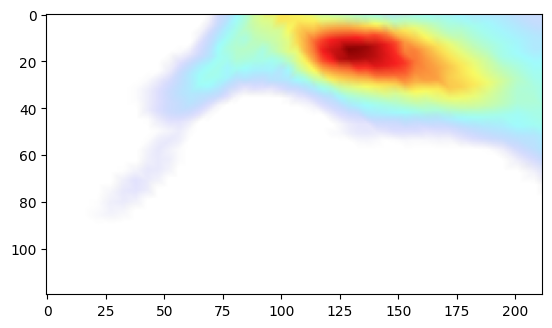

In [1437]:
from re import I
# example implementation
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import LinearNDInterpolator # for projection
import imageio.v3 as iio # read in image
from PIL import Image as im # convert to PNG
import time  # timer

# load and plot raw images
cai_rgb = iio.imread('/content/drive/MyDrive/M3DRavinCal/caimage.png')
compton_rgba = iio.imread('/content/drive/MyDrive/M3DRavinCal/compoverlay.png')

# do the stuff
start = time.time()
overlay_rgba = do_overlay(cai_rgb, compton_rgba, 10000) # this will show CA
print(time.time() - start)

# convert to PNG
overlay_png = im.fromarray(overlay_rgba)
plt.imshow(overlay_rgba)

In [1438]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
